In [1]:
import torch
print(torch.__version__)

2.2.1+cu121


In [2]:
pip install sentencepiece


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install datasets


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datasets import load_dataset

ds = load_dataset(
    "DynamicSuperb/AutomaticSpeechRecognition_LJSpeech"
)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ds = ds["test"].train_test_split(test_size=0.2 ,seed=42)
train_ds = ds["train"]
test_ds = ds["test"]

In [6]:
def subset_dataset(dataset, fraction=0.8):
    subset_size = int(len(dataset) * fraction)  # Calculate 90% of the dataset size
    return dataset.select(range(subset_size))

# Example: taking 90% of the dataset
train_ds = subset_dataset(train_ds, fraction=0.9)

In [7]:
import numpy as np
def levenshtein_distance(ref, hyp):
    """Calculate the Levenshtien distance between two sequences"""
    m, n = len(ref), len(hyp)
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m
    
    if m < n :
        ref, hyp = hyp , ref
        m , n = n, m
        
    previous_row = range(n + 1)
    for i, c1 in enumerate(ref):
        current_row = [ i + 1]
        for j , c2 in enumerate(hyp):
            insertions = previous_row[ j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
            
        previous_row = current_row
    return previous_row[-1]

def normalize_text(text, ignore_case = False, remove_space = False):
    if ignore_case:
        text = text.lower()
    if remove_space:
        text = ''.join(text.split())
    return text

def calculate_errors(reference, hypothesis, ignore_case=False, remove_space=False, delimiter=None):
    reference = normalize_text(reference, ignore_case, remove_space)
    hypothesis = normalize_text(hypothesis, ignore_case, remove_space)

    if delimiter:
        reference = reference.split(delimiter)
        hypothesis = hypothesis.split(delimiter)

    edit_distance = levenshtein_distance(reference, hypothesis)
    ref_len = len(reference)

    return float(edit_distance), ref_len

def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, False, delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    return edit_distance / ref_len

def cer(reference, hypothesis, ignore_case=False, remove_space=False):

    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    return edit_distance / ref_len
            

In [8]:
import os
print(os.environ.get('CUDA_VISIBLE_DEVICES'))

None


In [9]:
import string
from itertools import dropwhile

class TextTransform:
    def __init__(self):
        
        additional_chars = ["''", '<SPACE>']
        all_chars = additional_chars + list(string.ascii_lowercase)
       
        self.char_map = {char: i for i, char in enumerate(all_chars)}
        self.index_map = {index: char for char, index in self.char_map.items()}
        self.index_map[self.char_map['<SPACE>']] = ' ' 
        
    def text_to_int(self, text):
        return [self.char_map.get(c, self.char_map['<SPACE>']) for c in text.lower()]
    
    def int_to_text(self, labels):
        return ''.join(self.index_map[i] for i in labels).replace('<SPACE>', ' ')
    
    def int_to_text_remove_pad(self, int_sequence):
        text_sequence = list(dropwhile(lambda x: x == 0, reversed(int_sequence)))[::-1]
        text = ''.join(self.index_map[i] for i in text_sequence).replace('<SPACE>', ' ')
        return text
    
text_transform = TextTransform()
test_text = 'This is Farah'
test_ints = text_transform.text_to_int(test_text)
recovered_text = text_transform.int_to_text(test_ints)

print(f"original: {test_text}")
print(f"Converted to Int : {test_ints}")
print(f"Recoverd text: {recovered_text}")

original: This is Farah
Converted to Int : [21, 9, 10, 20, 1, 10, 20, 1, 7, 2, 19, 2, 9]
Recoverd text: this is farah


In [10]:
import torch
import torchaudio
import numpy as np

def speed_perturbation(waveform, speed_factor):
    new_sample_rate = int(16000 * speed_factor)  
    resampler = torchaudio.transforms.Resample(orig_freq=16000, new_freq=new_sample_rate).to(waveform.device)
    resampled_waveform = resampler(waveform)
    return resampled_waveform

def volume_perturbation(waveform, volume_factor):
    return waveform * volume_factor

def augment_audio(waveform):
    augmented_waveforms = []
    augmented_waveforms.append(waveform)  # Original
    augmented_waveforms.append(speed_perturbation(waveform, 1.1))  # Speed up
    augmented_waveforms.append(speed_perturbation(waveform, 0.9))  # Slow down
    augmented_waveforms.append(volume_perturbation(waveform, 0.7))  # Quieter
    augmented_waveforms.append(volume_perturbation(waveform, 1.5))  # Louder

    return augmented_waveforms

def process_data_on_gpu(dataset, batch_size=10):
    augmented_data = []
    batch = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for idx, entry in enumerate(dataset):
        # Get the waveform tensor and move to GPU
        waveform = torch.tensor(entry['audio']['array'], dtype=torch.float32).to(device)
        augmented_waveforms = augment_audio(waveform)
        for augmented_waveform in augmented_waveforms:
            batch.append({
                'file': entry['file'],
                'audio': {
                    'array': augmented_waveform.cpu().numpy(),  # Move back to CPU for storage
                    'sampling_rate': 16000
                },
                'label': entry['label'],
                'instruction': entry['instruction']
            })
        if len(batch) >= batch_size:
            augmented_data.extend(batch)
            batch = []  # Clear batch to free memory
            torch.cuda.empty_cache()  # Clear GPU memory
    if batch:
        augmented_data.extend(batch)

    return augmented_data


augmented_data = process_data_on_gpu(train_ds, batch_size=10)




In [11]:
import torch
import torch.nn as nn
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_mels = 128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()
waveform = torch.tensor(augmented_data[0]['audio']['array'], dtype=torch.float32)
_, audio, sample_rate, _ = augmented_data[0]
spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
print(spec.shape)

torch.Size([852, 128])


/usr/local/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [12]:
def data_processing(data, data_type = 'train'):
    if data_type not in ['train', 'valid']:
        raise ValueError("data_type should be either 'trian' or 'valid.'")

    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []

    audio_transforms = train_audio_transforms if data_type == 'train' else valid_audio_transforms

    for item in data:
        audio = torch.tensor(item['audio']['array'], dtype=torch.float32)
        original_sentence = item['label']

        spec = audio_transforms(audio).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(original_sentence.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first = True).unsqueeze(1).transpose(2,3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first = True)
    return spectrograms, labels, input_lengths, label_lengths

In [13]:
import torch.utils.data as data

pipeline_params = {
    'batch_size': 10,
    'epochs': 1,
    'learning_rate': 5e-4,
    'n_cnn_layers': 3,
    'n_rnn_layers':5,
    'rnn_dim': 512,
    'n_class': 29,
    'n_feats':  128,
    'stride': 2,
    'dropout': 0.5
}

kwargs = {'num_workers':1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(dataset = augmented_data,
                              batch_size = pipeline_params['batch_size'],
                              shuffle = True,
                              collate_fn = lambda x: data_processing(x, 'train'),
                              **kwargs)
test_loader = torch.utils.data.DataLoader(dataset = test_ds,
                             batch_size = pipeline_params['batch_size'],
                             shuffle = True,
                             collate_fn=lambda x: data_processing(x, 'valid'),
                             **kwargs)

Plotting audio and original sentence for sample 0:


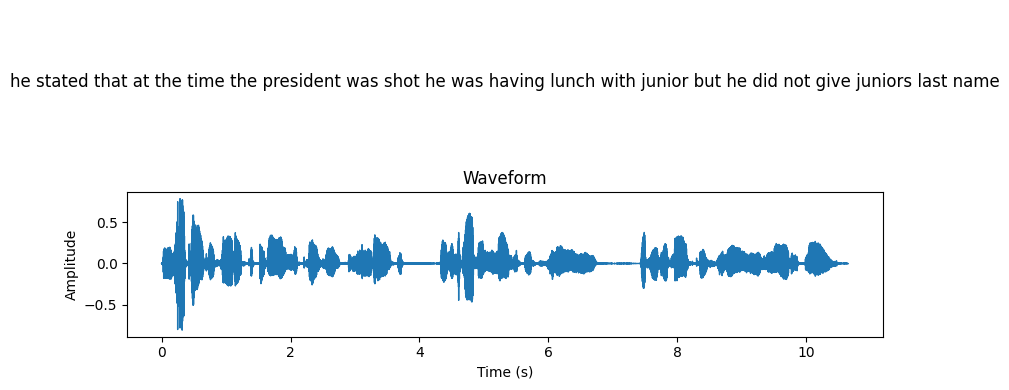

In [14]:
import torch
import torchaudio
import matplotlib.pyplot as plt


def plot_audio_with_sentence(audio, sentence, sample_rate=16000):
    time_axis = torch.arange(0, len(audio)) / sample_rate
    plt.figure(figsize=(10, 4))

    plt.subplot(2, 1, 1)
    plt.text(0.5, 0.5, sentence, horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.axis('off') 

    plt.subplot(2, 1, 2)
    plt.plot(time_axis, audio.numpy(), linewidth=1.0)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform')

    plt.tight_layout()
    plt.show()


for idx in range(1):
    audio = torch.tensor(train_ds[idx]['audio']['array'], dtype=torch.float32)
    original_sentence = train_ds[idx]['label']

    print(f"Plotting audio and original sentence for sample {idx}:")
    plot_audio_with_sentence(audio, original_sentence)


Playing audio file 1/9432


Waveform shape: torch.Size([170397])
Spectrogram shape: torch.Size([64, 852])
Sample rate: 16000
Label: he stated that at the time the president was shot he was having lunch with junior but he did not give juniors last name


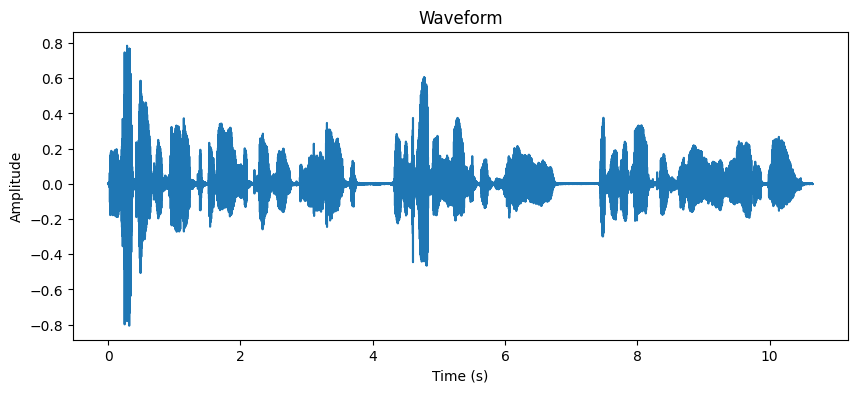

Playing audio file 2/9432


Waveform shape: torch.Size([126877])
Spectrogram shape: torch.Size([64, 635])
Sample rate: 16000
Label: soon afterward at about three pm police officers arrived and searched the house


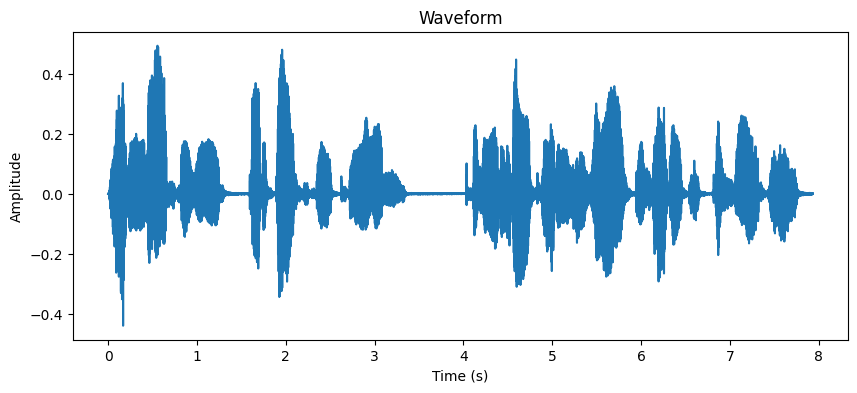

Playing audio file 3/9432


Waveform shape: torch.Size([210333])
Spectrogram shape: torch.Size([64, 1052])
Sample rate: 16000
Label: and when interrogated about a cab ride oswald also admitted that he left the slowmoving bus and took a cab to his roominghouse


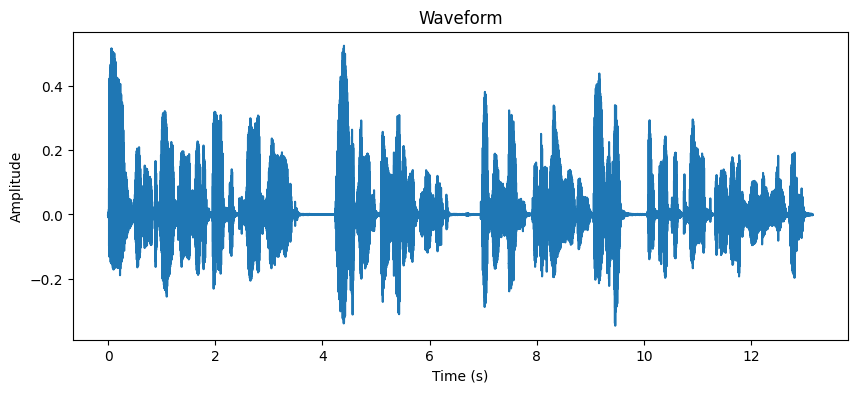

Playing audio file 4/9432


Waveform shape: torch.Size([189341])
Spectrogram shape: torch.Size([64, 947])
Sample rate: 16000
Label: they were accordingly apprehended and brought to trial the informer hanfield by name being accepted as kings evidence


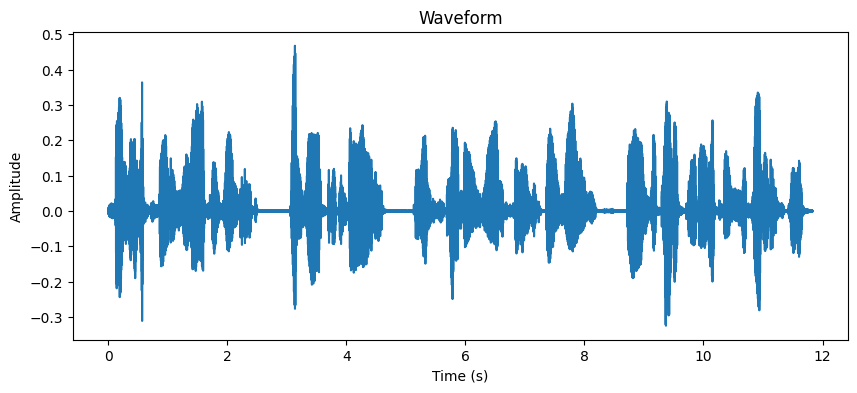

Playing audio file 5/9432


Waveform shape: torch.Size([82845])
Spectrogram shape: torch.Size([64, 415])
Sample rate: 16000
Label: in the cells the foods undergo metabolic changes


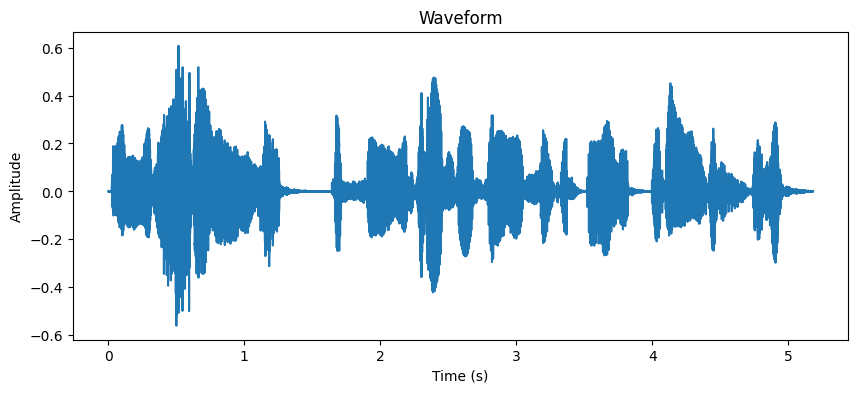

In [15]:
import torchaudio
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio

def play_audio_with_info(audio_array, original_sentence, sample_rate=16000):
    display(Audio(audio_array.numpy(), rate=sample_rate))
    print('Waveform shape:', audio_array.shape)

    # Generate and display Mel spectrogram
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64)(audio_array)
    print('Spectrogram shape:', mel_spectrogram.shape)
    print('Sample rate:', sample_rate)
    print("Label:", original_sentence)

    # Plot waveform
    plt.figure(figsize=(10, 4))
    time_axis = torch.arange(0, len(audio_array)) / sample_rate
    plt.plot(time_axis.numpy(), audio_array.numpy())
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()



total_files = len(train_ds)

for i in range(5):
    audio_array = torch.tensor(train_ds[i]['audio']['array'], dtype=torch.float32)
    original_sentence = train_ds[i]['label']

    print(f'Playing audio file {i + 1}/{total_files}')
    play_audio_with_info(audio_array, original_sentence)


Data shape: (162,)


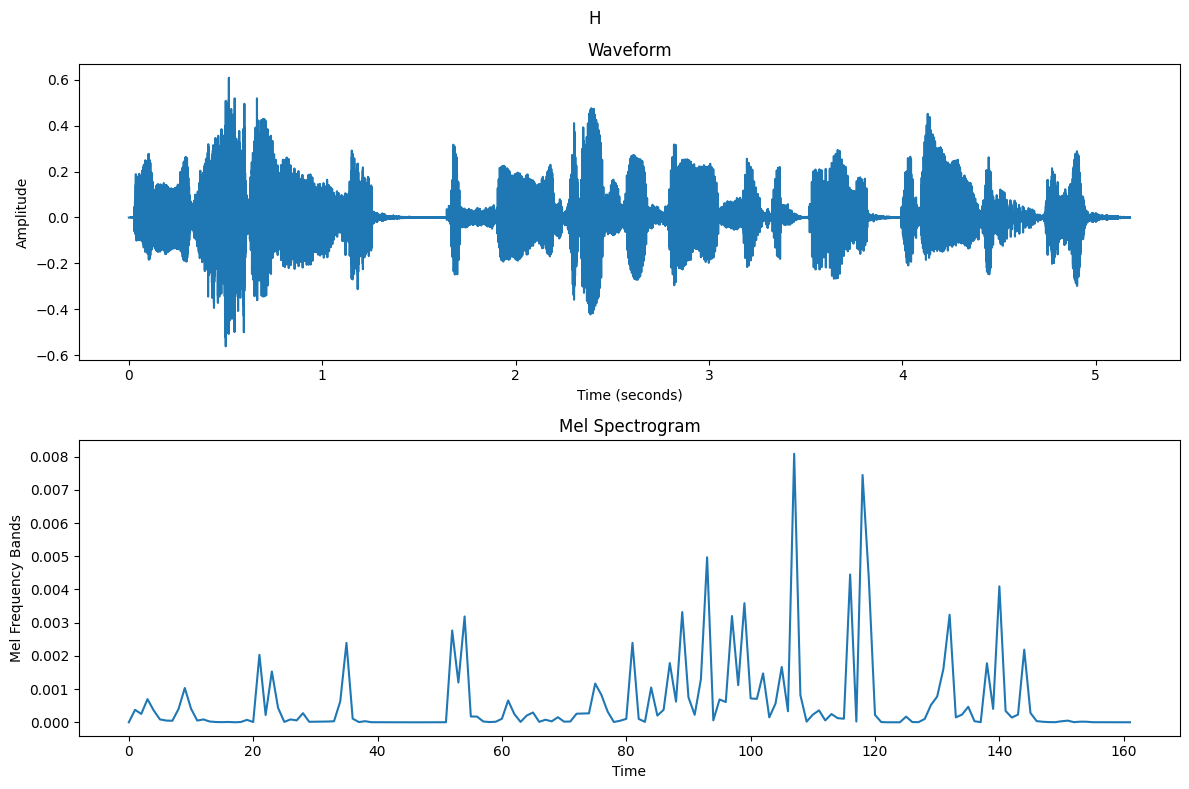

In [16]:
import matplotlib.pyplot as plt
import numpy as np
transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_mels=128,  # You can adjust this
    n_fft=1024,  # FFT window size
    hop_length=512  # Hop length (number of samples between frames)
)

mel_spectrogram = transform(audio_array)
sample_rate=16000
def plot_spectrogram_or_waveform(data, ax, is_spectrogram=True):
    # Check if the data is a tensor, and convert to numpy if needed
    if isinstance(data, torch.Tensor):
        data = data.detach().numpy()

    # Check the shape of the data
    print(f"Data shape: {data.shape}")

    # Handle 1D data (e.g., waveforms)
    if data.ndim == 1:
        ax.plot(np.arange(len(data)), data)
        ax.set_title('Waveform')
        ax.set_xlabel('Time')
        ax.set_ylabel('Amplitude')
        return

    # Handle 2D spectrograms
    if data.ndim == 2:
        log_spec = np.log(data + 1e-10)
        height, width = log_spec.shape[:2]
        X = np.linspace(0, width, num=width)
        Y = np.linspace(0, height, num=height)
        c = ax.pcolormesh(X, Y, log_spec, shading='auto', cmap='viridis')
        plt.colorbar(c, ax=ax)
        ax.set_title('Spectrogram')
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
    else:
        raise ValueError(f"Data must have either 1 or 2 dimensions, but got shape: {data.shape}")

fig, axes = plt.subplots(2, figsize=(12, 8))

timescale = np.arange(audio_array.shape[0]) / sample_rate
axes[0].plot(timescale, audio_array.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_ylabel('Amplitude')

plot_spectrogram_or_waveform(mel_spectrogram[0], axes[1])

axes[1].set_title('Mel Spectrogram')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Mel Frequency Bands')

audio_array = torch.tensor(train_ds[i]['audio']['array'], dtype=torch.float32)
original_sentence = train_ds[i]['label']
plt.suptitle(original_sentence[i].title())
plt.tight_layout()
plt.show()


In [17]:
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

print("Picked device:", device)

import torch.nn as nn
class CNNLayerNorm(nn.Module):
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)

class ResidualCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

False
Picked device: cpu


# Speech Recognition Model

In [18]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  
        
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x
pipeline_params = {
    'batch_size': 10,
    'epochs': 1,
    'learning_rate': 5e-4,
    'n_cnn_layers': 3,
    'n_rnn_layers':5,
    'rnn_dim': 512,
    'n_class': 29,
    'n_feats':  128,
    'stride': 2,
    'dropout': 0.5
}

model = SpeechRecognitionModel(pipeline_params['n_cnn_layers'], pipeline_params['n_rnn_layers'], pipeline_params['rnn_dim'], pipeline_params['n_class'], pipeline_params['n_feats'], pipeline_params['stride'], pipeline_params['dropout']).to(device)

In [19]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

optimizer = optim.AdamW(model.parameters(), pipeline_params["learning_rate"])

criterion = nn.CTCLoss(blank=28).to(device)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=pipeline_params["learning_rate"],
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=pipeline_params["epochs"],
                                        anneal_strategy="linear")

In [20]:


# data_len = len(train_loader.dataset)
# logging_idx = 0
# logging_freq = 100
# for epoch in range(pipeline_params["epochs"]):
#     progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{pipeline_params['epochs']}", unit="batches")
#     for batch_idx, _data in progress_bar:
#         spectrograms, labels, input_lengths, label_lengths = _data
#         spectrograms, labels = spectrograms.to(device), labels.to(device)

#         optimizer.zero_grad()

#         output = model(spectrograms)
#         output = F.log_softmax(output, dim=2)
#         output = output.transpose(0, 1)

#         loss = criterion(output, labels, input_lengths, label_lengths)
#         loss.backward()

#         optimizer.step()
#         scheduler.step()
#         if logging_idx % logging_freq == 0:
#             print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
#                 epoch, 
#                 batch_idx * len(spectrograms), 
#                 data_len, 100. * batch_idx / len(train_loader), 
#                 loss.item()
#             ))
#         logging_idx += 1
#         progress_bar.set_postfix({'loss': loss.item()})


In [21]:

# model_path = '/kaggle/working/speech_recognition_model.pth'
# torch.save(model.state_dict(), model_path)

# Decoding

In [22]:
import torch

def greedy_decoder(output_probs, blank_label=28):
    """Decodes the output probabilities to the most likely indices sequence."""
    max_probs, indices = torch.max(output_probs, dim=2)
    decoded_batches = []

    for idx, sequence in enumerate(indices.transpose(0, 1)):
        previous = -1
        decoded_sequence = []

        for label_index in sequence:
            if label_index != previous and label_index != blank_label:
                decoded_sequence.append(label_index.item())
            previous = label_index

        decoded_batches.append(decoded_sequence)

    return decoded_batches


In [23]:
import torch
import torch.nn.functional as F

text_transform = TextTransform()

def validate(model, validation_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        all_predicted_texts = []
        all_true_texts = []
        for batch_idx, _data in tqdm(enumerate(validation_loader)):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            output = model(spectrograms)
            output =F.log_softmax(output, dim = 2)
            output = output.transpose(0, 1) # Needed for CTCLoss
            loss = criterion(output, labels, input_lengths, label_lengths)
            total_loss += loss.item()
            decoded_outputs = greedy_decoder(output)
            predicted_texts = [text_transform.int_to_text(seq) for seq in decoded_outputs]
            true_texts  = [text_transform.int_to_text(label.tolist()) for label in labels]
            
            all_predicted_texts.extend(predicted_texts)
            all_true_texts.extend(true_texts)
            
        avg_loss = total_loss / len(validation_loader)
        avg_wer = np.mean([wer(ref, hyp) for ref, hyp in zip(all_true_texts,all_predicted_texts)])
        avg_cer = np.mean([cer(ref, hyp) for ref, hyp in zip(all_true_texts, all_predicted_texts)])
        
        print(f"Validation Loss: {avg_loss}")
        print(f"Average WER: {avg_wer:.4f}")
        print(f"Average CER: {avg_cer:.4f}")
        
    

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model.load_state_dict(torch.load('/kaggle/input/speech/pytorch/default/1/speech_recognition_model.pth', map_location=device))

<All keys matched successfully>

In [26]:
validate(model, test_loader, criterion, device)

/usr/local/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
262it [03:53,  1.23it/s]/usr/local/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
262it [03:54,  1.12it/s]


Validation Loss: 1.29695501605063
Average WER: 0.8885
Average CER: 0.6327


In [27]:
def speech_to_text(audio_data, model, device, text_transform, valid_audio_transforms):
    waveform = audio_data['audio']['array']
    sample_rate = audio_data['audio']['sampling_rate']
    waveform = valid_audio_transforms(waveform.unsqueeze(0))  
    waveform = waveform.to(device)
    output = model(waveform)
    output = F.log_softmax(output, dim=2)
    output = output.transpose(0, 1)
    decoded_output = greedy_decoder(output)
    predicted_text = text_transform.int_to_text(decoded_output[0])
    
    return predicted_text

In [28]:
# import torch

# # Save the model
# torch.save(model.state_dict(), '/kaggle/working/speech_recognition_model.pt')


In [29]:
import torchaudio
model = SpeechRecognitionModel(pipeline_params['n_cnn_layers'],
                               pipeline_params['n_rnn_layers'],
                               pipeline_params['rnn_dim'],
                               pipeline_params['n_class'],
                               pipeline_params['n_feats'],
                               pipeline_params['stride'],
                               pipeline_params['dropout']).to(device)


model.load_state_dict(torch.load('/kaggle/input/speech/pytorch/default/1/speech_recognition_model.pth', map_location=device))
text_transform = TextTransform()
valid_audio_transforms = torchaudio.transforms.MelSpectrogram()



def speech_to_text(audio_sample, model, device, text_transform, valid_audio_transforms):
    waveform = audio_sample['audio']['array']
    sample_rate = audio_sample['audio']['sampling_rate']
    waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)  
    waveform_tensor = waveform_tensor.unsqueeze(1)  
    waveform_tensor = valid_audio_transforms(waveform_tensor)
    print(f"Waveform tensor shape before model input: {waveform_tensor.shape}")
    waveform_tensor = waveform_tensor.to(device)
    output = model(waveform_tensor)
    output = F.log_softmax(output, dim=2)
    output = output.transpose(0, 1)
    decoded_output = greedy_decoder(output)
    predicted_text = text_transform.int_to_text(decoded_output[0])

    return predicted_text


audio_sample = test_ds[1]  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predicted_text = speech_to_text(audio_sample, model, device, text_transform, valid_audio_transforms)
print(f"Predicted Text: {predicted_text}")


/usr/local/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Waveform tensor shape before model input: torch.Size([1, 1, 128, 1018])
Predicted Text: whi s sit fom losandealas on march  renty mintin sixtythre and he laffer neorlans on ape wunt forr manten sixtytre


In [30]:
del augmented_data

In [31]:
del ds

In [32]:
del valid_audio_transforms,waveform,spec

In [33]:
del train_audio_transforms

In [34]:
del train_ds

In [35]:
from datasets import Dataset, load_dataset 
from transformers import MarianMTModel, MarianTokenizer 
model_name = "Helsinki-NLP/opus-mt-fr-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

/usr/local/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [36]:
csv_file_path = '/kaggle/input/language-translation-englishfrench/eng_-french.csv'
data = pd.read_csv(csv_file_path)
data.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [37]:
data.columns = ['en', 'fr']

In [38]:
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

In [39]:
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

In [40]:
def tokenize_function(examples):
    model_inputs = tokenizer(
        examples['en'],
        max_length=128,
        truncation=True,
        padding="max_length"
    )

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['fr'],
            max_length=128,
            truncation=True,
            padding="max_length"  # Add padding
        )

    # Replace -100 for padding token id in labels
    labels['input_ids'] = [label if label != tokenizer.pad_token_id else -100 for label in labels['input_ids']]
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [41]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/140497 [00:00<?, ? examples/s]/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3935: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 35124/35124 [00:06<00:00, 5832.50 examples/s]


In [42]:
# training_args = Seq2SeqTrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     learning_rate=7e-5,
#     per_device_train_batch_size=32,
#     per_device_eval_batch_size=32,
#     weight_decay=0.01,
#     save_total_limit=2,
#     num_train_epochs=5,
#     predict_with_generate=True,
#     fp16=True,
#     gradient_accumulation_steps=2
# )

In [43]:
# # Create the Trainer
# trainer = Seq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train_dataset,
#     eval_dataset=tokenized_test_dataset
# )

In [44]:
# # !pip install transformers datasets accelerate --upgrade
# from transformers import AutoTokenizer
# from datasets import load_dataset
# import accelerate

In [45]:
# # Train the model
# trainer.train()

In [46]:
# # Save the model after training
# trainer.save_model("/kaggle/working/")

In [47]:
tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")  # Replace with your specific model

# Save the model's state dictionary
#torch.save(trainer.model.state_dict(), "/kaggle/working/translation_model.pth")

# Save the tokenizer as well
tokenizer.save_pretrained("/kaggle/working/translation_tokenizer")


/usr/local/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


('/kaggle/working/translation_tokenizer/tokenizer_config.json',
 '/kaggle/working/translation_tokenizer/special_tokens_map.json',
 '/kaggle/working/translation_tokenizer/vocab.json',
 '/kaggle/working/translation_tokenizer/source.spm',
 '/kaggle/working/translation_tokenizer/target.spm',
 '/kaggle/working/translation_tokenizer/added_tokens.json')

In [48]:
from transformers import MarianMTModel, MarianTokenizer
import torch

# Path to the saved model and tokenizer
model_path = "/kaggle/input/translate/pytorch/default/1/translation_model.pth"
tokenizer_path = "/kaggle/working/translation_tokenizer"

# Load the tokenizer
tokenizer = MarianTokenizer.from_pretrained(tokenizer_path)

# Create an instance of the model architecture
# Make sure to use the same architecture as the one you used for training
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-fr")  # Replace with your specific model architecture

# Load the saved state dictionary into the model
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Load to CPU

# Set the model to evaluation mode (important when using the model for inference)
model.eval()

print("Model and tokenizer loaded successfully.")


Model and tokenizer loaded successfully.


In [49]:
# Path to the saved model and tokenizer
model_path = "/kaggle/input/translate/pytorch/default/1/translation_model.pth"
tokenizer_path = "/kaggle/working/translation_tokenizer"

# Load the tokenizer and translation model
from transformers import MarianMTModel, MarianTokenizer

tokenizer = MarianTokenizer.from_pretrained(tokenizer_path)
translation_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-fr")  # Or your specific model architecture
translation_model = translation_model.to(device)  # Move translation model to the correct device (CPU or CUDA)

# Translation function
def translate_text(english_text, translation_model, tokenizer, device):
    # Prepare inputs for translation
    inputs = tokenizer(english_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to device

    # Generate translation
    translated_tokens = translation_model.generate(**inputs)
    french_translation = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

    return french_translation

# Example usage:
french_output = translate_text(predicted_text, translation_model, tokenizer, device)
print(f"French Translation: {french_output}")


French Translation: Si on s'assoit fom losandedas sur la marche reny mintin soixanteième et il laffer néorlans sur le singe forten soixantetre
